# Assignment 6 - Kernel Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

from tqdm import tqdm

import os

## SVM to predict if the tumor is malignent or not

In [120]:
df = pd.read_csv('data/data_cancer.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

In [121]:
X = pd.get_dummies(df.drop('diagnosis', axis=1), drop_first=True)
y = pd.get_dummies(df['diagnosis'], drop_first=True)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.ravel(), test_size=0.2, random_state=1)

In [123]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [124]:
cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean()

0.9648221343873518

### Kernel Comparaison

Let's talk briefly about the scoring method. Here are the 3 mains methods we have:
- Recall: proportion of actual positive cases (malignant tumors) that the model correctly identifies.
- Precision: The proportion of predicted positive cases that are actually positive.
- F1: he harmonic mean of precision and recall
- (AUC-ROC): Measures the ability of the model to distinguish between classes (malignant vs. benign) across all thresholds.

For tumor detection, recall is typically the most important metric because **missing a malignant tumor (false negative) can have life-threatening consequences**.

100%|██████████| 4/4 [00:00<00:00, 29.73it/s]


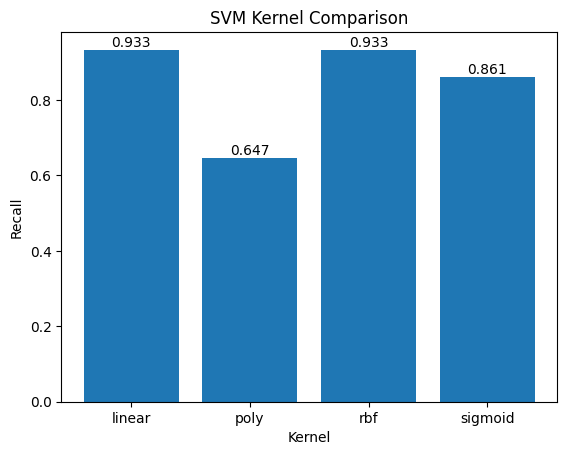

In [125]:
# try different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scores = []
for kernel in tqdm(kernels):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=kernel))
    clf.fit(X_train, y_train)
    scores.append(cross_val_score(clf, X_test, y_test, cv=5, scoring='recall').mean()) # recall is more important than accuracy

plt.bar(kernels, scores)
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Kernel')
plt.ylabel('Recall')
plt.title('SVM Kernel Comparison')
plt.show()

After testing different SVM kernels on the dataset, I found the following:

1. **Linear kernel (93.3% recall):** This kernel worked really well, meaning the data is mostly separable with a straight line. It's simple and effective.

2. **RBF kernel (93.3% recall):** This performed as best as the linear kernel. It’s more flexible and can handle complex patterns in the data, which can being improved after tuning hyperparameters.

3. **Polynomial kernel (64.7% recall):** This didn’t perform as well, likely because it is set to a default degree of 3, which might be too complex for this dataset. The complexity could lead to overfitting or poor generalization. Tuning hyperparameters like the degree of the polynomial or regularization parameters could potentially improve its performance.

4. **Sigmoid kernel (86.1% recall):** This kernel has a lower recall than the RBF and Linear kernel but still gave a decent score.


### Finding best hyperparameters for each method

In [130]:
grid_score = []

clf = make_pipeline(StandardScaler(), SVC())

In [132]:
# Grid search for hyperparameters and regularization parameters in the linear kernel
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__C': np.logspace(-2, 4, 7),
    'svc__kernel': ['linear']
}

grid = GridSearchCV(clf, param_grid, cv=10, scoring='recall')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(f'Best train score: {grid.best_score_:.3f}')
test_score = grid.score(X_test, y_test)
print(f'Test score (linear kernel): {test_score:.3f}')

grid_score.append(test_score)

{'svc__C': 1.0, 'svc__kernel': 'linear'}
Best train score: 0.959
Test score (linear kernel): 0.929


In [133]:
# Grid search for hyperparameters and regularization parameters in the poly kernel
param_grid = {
    'svc__C': np.logspace(-3, 3, 7),
    'svc__gamma': np.logspace(-3, 3, 7),
    'svc__kernel': ['poly'],
    'svc__degree': [2, 3, 4]
}

grid = GridSearchCV(clf, param_grid, cv=10, scoring='recall')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(f'Best train score: {grid.best_score_:.3f}')
test_score = grid.score(X_test, y_test)
print(f'Test score (poly kernel): {test_score:.3f}')

grid_score.append(test_score)

{'svc__C': 0.001, 'svc__degree': 3, 'svc__gamma': 10.0, 'svc__kernel': 'poly'}
Best train score: 0.935
Test score (poly kernel): 0.857


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [134]:
# Grid search for hyperparameters and regularization parameters in the rbf kernel
param_grid = {
    'svc__C': np.logspace(-3, 3, 7),
    'svc__gamma': np.logspace(-3, 3, 7),
    'svc__kernel': ['rbf']
}

grid = GridSearchCV(clf, param_grid, cv=10, scoring='recall')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(f'Best train score: {grid.best_score_:.3f}')
test_score = grid.score(X_test, y_test)
print(f'Test score (RBF kernel): {test_score:.3f}')

grid_score.append(test_score)

{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best train score: 0.965
Test score (RBF kernel): 0.952


In [135]:
# Grid search for hyperparameters and regularization parameters in the sigmoid kernel
param_grid = {
    'svc__C': np.logspace(-5, 1, 7),
    'svc__gamma': np.logspace(-3, 3, 7),
    'svc__kernel': ['sigmoid']
}

grid = GridSearchCV(clf, param_grid, cv=10, scoring='recall')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(f'Best train score: {grid.best_score_:.3f}')
test_score = grid.score(X_test, y_test)
print(f'Test score (Sigmoid kernel): {test_score:.3f}')

grid_score.append(test_score)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid'}
Best train score: 0.929
Test score (Sigmoid kernel): 0.905


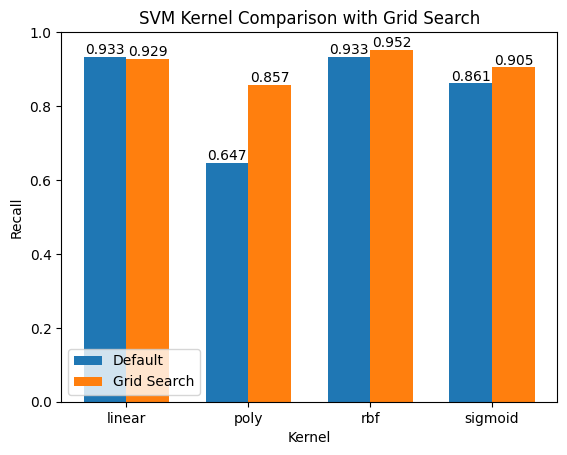

In [142]:
# plot the results compared to the previous results 
bar_width = 0.35
index = np.arange(len(kernels))

plt.bar(index, scores, bar_width, label='Default')
plt.bar(index + bar_width, grid_score, bar_width, label='Grid Search')

for i in range(len(grid_score)):
    plt.text(i, scores[i], f'{scores[i]:.3f}', ha='center', va='bottom')
    plt.text(i + bar_width, grid_score[i], f'{grid_score[i]:.3f}', ha='center', va='bottom')

plt.xlabel('Kernel')
plt.ylabel('Recall')
plt.title('SVM Kernel Comparison with Grid Search')
plt.xticks(index + bar_width / 2, kernels)
plt.legend()
plt.show()

After implementing 10-fold GridSearchCV, for all 4 kernels we noticed:
- the linear kernel has not made improvement. Logic, because the linear model doesn't have hyperparameter.
- The poly kernel (with best degree = 3) has made a huge improvement, but is still way below the best models in terms of Recall. Moreover, if we check at the `grid.best_score_ = 0.935` compared to the actual `grid.test_score = 0.857`, we see a clear trend of overfitting, even with tuned regularization parameters.
- The RBF kernel has made a little improvement. It is the best kernel choice in terms of sensitivity (recall), which is important in our case.
- The sigmoïd kernel has improved as well, but is still behind the RBF and the linear kernels.

## Implement kernel ridge regression by hand

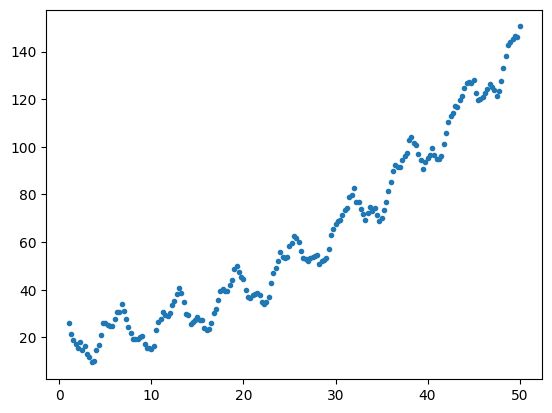

In [2]:
# import the data
data = pd.read_csv('data/data.csv')

# plot the data
plt.scatter(data['x'], data['y'], marker='.')
plt.show()

In [3]:
# shuffle the data
data = shuffle(data)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['x'].values, data['y'].values.ravel(), test_size=0.2, random_state=1)

In [4]:
# implement polynomial kernel by hand
def polynomial_k(v, w, p=2, c=1, gamma=1):
    return ((v[:, np.newaxis] * w) + c) ** p

def linear_k(v, w, p=2, c=1, gamma=1):
    return v[:, np.newaxis] * w

def rbf_k(v, w, p=2, c=1, gamma=1):
    # this one works only if v and w are 1D arrays    
    sq_dist = -2*v[:, np.newaxis] * w + v[:, np.newaxis]**2 + w**2
    return np.exp(-gamma * sq_dist)

def sigmoid_k(v, w, p=2, c=1, gamma=1):
    return np.tanh(gamma * (v[:, np.newaxis] * w) + c) 

# implement the SVM algorithm by hand
# we want to find alpha = (K + lambda * I)^-1 * y
def fit(X_train, y_train, kernel, p=2, c=1, l=1, gamma=1): # l is the regularization parameter lambda
    n = X_train.shape[0]
    K = kernel(X_train, X_train, p, c, gamma)
    alpha = np.linalg.inv(K+l*np.eye(n)).dot(y_train)
    return alpha

def predict(X_test, X_train, alpha, kernel, p=2, c=1, gamma=1):
    K = kernel(X_test, X_train, p, c, gamma=1)
    return K.dot(alpha)

In [5]:
# fit the polynomial kernel
alpha = fit(X_train, y_train, polynomial_k)

In [6]:
# predict the polynomial kernel
y_pred = predict(X_test, X_train, alpha, polynomial_k)

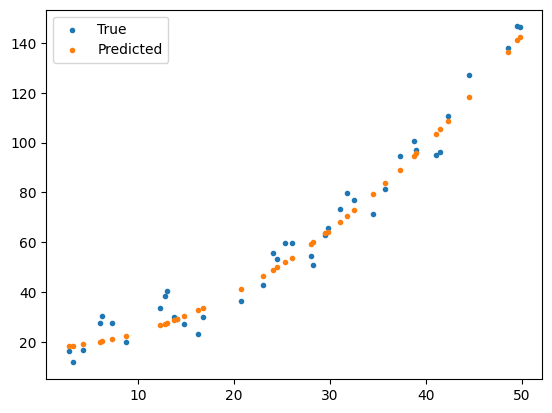

In [7]:
# plot the results
plt.scatter(X_test, y_test, marker='.', label='True')
plt.scatter(X_test, y_pred, marker='.', label='Predicted')
plt.legend()
plt.show()

In [8]:
# now lets compare the erros with cross validation with MSE
def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def cross_val(X, y, kernel, p=2, c=1, l=1, gamma=1, cv=5):
    n = X.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    splits = np.array_split(idx, cv)
    errors = []
    for i in range(cv):
        test_idx = splits[i]
        train_idx = np.concatenate([splits[j] for j in range(cv) if j != i])
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        alpha = fit(X_train, y_train, kernel, p, c, l, gamma)
        y_pred = predict(X_test, X_train, alpha, kernel, p, c, gamma)
        errors.append(mse(y_test, y_pred))
    return np.mean(errors)

In [12]:
# optimize the hyperparameters
# for the rbf kernel
param_grid = {
    'l': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

errors_rbf_grid = []
for l in tqdm(param_grid['l']):
    for gamma in param_grid['gamma']:
        errors_rbf_grid.append(cross_val(X_train, y_train, rbf_k, l=l, gamma=gamma))

errors_rbf_grid = np.array(errors_rbf_grid).reshape(7, 7)

# find the best hyperparameters
best_idx = np.unravel_index(np.argmin(errors_rbf_grid), errors_rbf_grid.shape)
l_rbf = param_grid['l'][best_idx[0]]
gamma_rbf = param_grid['gamma'][best_idx[1]]
print(f'Best lambda: {l_rbf}')
print(f'Best gamma: {gamma_rbf}')
print(f'Error: {errors_rbf_grid[best_idx]}')

100%|██████████| 7/7 [00:01<00:00,  6.41it/s]

Best lambda: 0.001
Best gamma: 1.0
Error: 31.651996115947163


In [13]:
# for the poly kernel
param_grid = {
    'l': np.logspace(-3, 3, 7),
    'p': [2, 3, 4],
    'c': np.logspace(-3, 3, 7)
}

errors_rbf_grid = []
for l in tqdm(param_grid['l']):
    for p in param_grid['p']:
        for c in param_grid['c']:
            errors_rbf_grid.append(cross_val(X_train, y_train, polynomial_k, l=l, p=p, c=c))

errors_rbf_grid = np.array(errors_rbf_grid).reshape(7, 3, 7)

# find the best hyperparameters
best_idx = np.unravel_index(np.argmin(errors_rbf_grid), errors_rbf_grid.shape)
l_poly = param_grid['l'][best_idx[0]]
p_poly = param_grid['p'][best_idx[1]]
c_poly = param_grid['c'][best_idx[2]]
print(f'Best lambda: {l_rbf}')
print(f'Best p: {p_poly}')
print(f'Best c: {c_poly}')
print(f'Error: {errors_rbf_grid[best_idx]}')

100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

Best lambda: 0.001
Best p: 3
Best c: 10.0
Error: 37.60855850845976


In [ ]:
# compare the errors for different kernels
errors = []
errors.append(cross_val(X_train, y_train, linear_k))
errors.append(cross_val(X_train, y_train, polynomial_k, p=p_poly, c=c_poly, l=l_poly))
errors.append(cross_val(X_train, y_train, rbf_k, l=l_rbf, gamma=gamma_rbf))

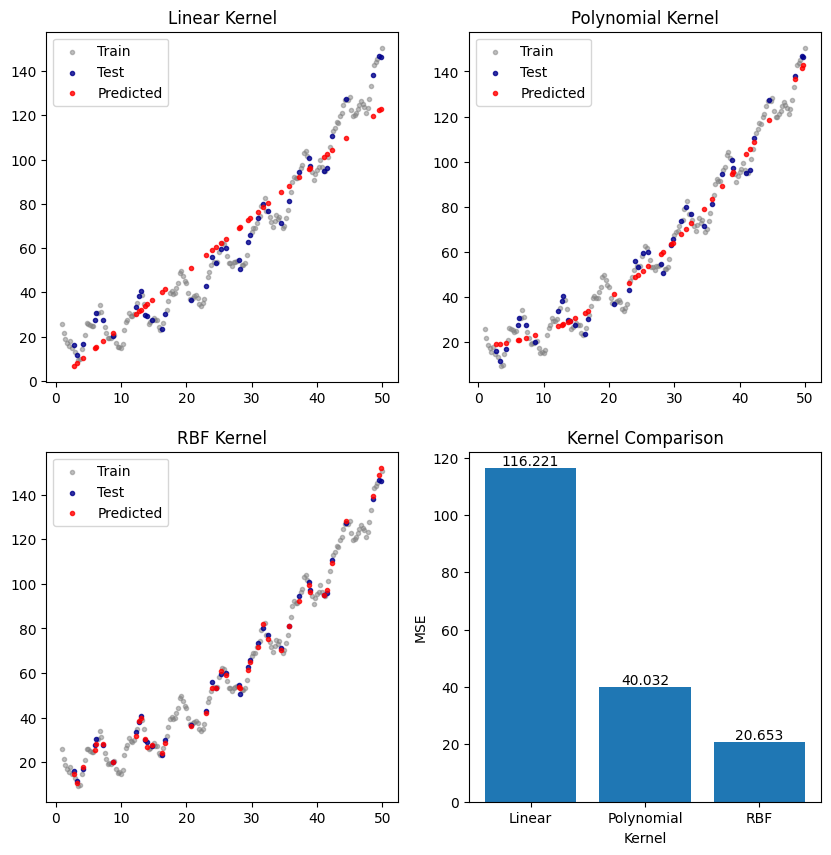

In [31]:
# create a 2x2 grid of plots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# fit the linear, polynomial, and rbf kernels (sigmoid not useful for regression)
alpha = fit(X_train, y_train, linear_k)
y_pred = predict(X_test, X_train, alpha, linear_k)
ax[0, 0].scatter(X_train, y_train, marker='.', label='Train', alpha=0.5, color='gray')
ax[0, 0].scatter(X_test, y_test, marker='.', label='Test', alpha=0.8, color='darkblue')
ax[0, 0].scatter(X_test, y_pred, marker='.', label='Predicted', alpha=0.8, color='red')
ax[0, 0].set_title('Linear Kernel')
ax[0, 0].legend()

alpha = fit(X_train, y_train, polynomial_k, p=p_poly, c=c_poly, l=l_poly)
y_pred = predict(X_test, X_train, alpha, polynomial_k, p=p_poly, c=c_poly)
ax[0, 1].scatter(X_train, y_train, marker='.', label='Train', alpha=0.5, color='gray')
ax[0, 1].scatter(X_test, y_test, marker='.', label='Test', alpha=0.8, color='darkblue')
ax[0, 1].scatter(X_test, y_pred, marker='.', label='Predicted', alpha=0.8, color='red')
ax[0, 1].set_title('Polynomial Kernel')
ax[0, 1].legend()

alpha = fit(X_train, y_train, rbf_k, l=l_rbf, gamma=gamma_rbf)
y_pred = predict(X_test, X_train, alpha, rbf_k, gamma=gamma_rbf)
ax[1, 0].scatter(X_train, y_train, marker='.', label='Train', alpha=0.5, color='gray')
ax[1, 0].scatter(X_test, y_test, marker='.', label='Test', alpha=0.8, color='darkblue')
ax[1, 0].scatter(X_test, y_pred, marker='.', label='Predicted', alpha=0.8, color='red')
ax[1, 0].set_title('RBF Kernel')
ax[1, 0].legend()

ax[1,1].bar(['Linear', 'Polynomial', 'RBF'], errors)
for i in range(len(errors)):
    ax[1,1].text(i, errors[i], f'{errors[i]:.3f}', ha='center', va='bottom')
ax[1,1].set_xlabel('Kernel')
ax[1,1].set_ylabel('MSE')
ax[1,1].set_title('Kernel Comparison')
plt.show()

### Results
The barchart of kernel comparaison MSE (using 5 fold cross validation) gives us a clear winner. Indeed, the RBF kernel has the lowest MSE, followed by the polynomial kernel. The linear kernel has a really high MSE, as it cannot captures the smooths changes in the dataset, but only the trend. 

Indeed, the figure above illustrates this well the linear and polynomial kernel are modelling only the global trend of the dataset, whereas the RBF managed to handle the underlying pattern of the data.